In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt

class GradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic', epsilon=1e-4,
                 track_history=False):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.epsilon = epsilon
        self.track_history = track_history
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be 'cubic' or 'pchip'")
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = np.mean(X[mask_1], axis=0)
        self.m0 = np.mean(X[~mask_1], axis=0)

    def _initialize_control_points(self, X):
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        y_range = y_max - y_min
        self.control_x = np.linspace(x_min, x_max, self.n_control_points)
        y_mid = (self.m0[1] + self.m1[1]) / 2
        self.control_y = np.random.uniform(y_mid - y_range * 0.05, y_mid + y_range * 0.05, self.n_control_points)
        # Removed: self.control_y[0] = self.control_y[1], self.control_y[-1] = self.control_y[-2]
        self.initial_control_x = self.control_x.copy()
        self.initial_control_y = self.control_y.copy()

    def _fit_spline(self):
        # Ensure control_x is strictly increasing
        sorted_idx = np.argsort(self.control_x)
        self.control_x = self.control_x[sorted_idx]
        self.control_y = self.control_y[sorted_idx]
        if self.spline_type == 'cubic':
            self.spline = CubicSpline(self.control_x, self.control_y, bc_type='natural')  # Changed to natural for flexibility
        else:
            self.spline = PchipInterpolator(self.control_x, self.control_y)

    def _calculate_displacement(self, X):
        return X[:, 1] - self.spline(X[:, 0])

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.reshape(1, -1))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _compute_gradients(self, X, y):
        displacements = self._calculate_displacement(X)
        pseudo_labels = self._update_pseudo_labels(X, y)
        errors = displacements * pseudo_labels <= 0
        error_indices = np.where(errors)[0]

        if len(error_indices) == 0:
            return np.zeros_like(self.control_x), np.zeros_like(self.control_y)

        X_err = X[error_indices, 0]
        y_err = y[error_indices]
        ti = np.where(y_err == 1, 1, -1)
        sign_theta = self.class_1_pseudo

        base_spline = self.spline(X_err)
        n_points = len(self.control_x)
        grad_x = np.zeros(n_points)
        grad_y = np.zeros(n_points)
        perturbed_diff_x = np.zeros((n_points, len(X_err)))
        perturbed_diff_y = np.zeros((n_points, len(X_err)))

        for j in range(n_points):
            control_x_pert = self.control_x.copy()
            control_x_pert[j] += self.epsilon
            sorted_idx = np.argsort(control_x_pert)
            if self.spline_type == 'cubic':
                spline_pert = CubicSpline(control_x_pert[sorted_idx], self.control_y[sorted_idx], bc_type='natural')
            else:
                spline_pert = PchipInterpolator(control_x_pert[sorted_idx], self.control_y[sorted_idx])
            perturbed_diff_x[j] = spline_pert(X_err) - base_spline

            control_y_pert = self.control_y.copy()
            control_y_pert[j] += self.epsilon
            if self.spline_type == 'cubic':
                spline_pert = CubicSpline(self.control_x, control_y_pert, bc_type='natural')
            else:
                spline_pert = PchipInterpolator(self.control_x, control_y_pert)
            perturbed_diff_y[j] = spline_pert(X_err) - base_spline

        # Apply gradients in original order
        grad_x += (ti * sign_theta) @ (perturbed_diff_x.T / self.epsilon)
        grad_y += (ti * sign_theta) @ (perturbed_diff_y.T / self.epsilon)

        # Regularization
        grad_x[1:] += 2 * self.lambda_reg * (self.control_x[1:] - self.control_x[:-1])
        grad_x[:-1] -= 2 * self.lambda_reg * (self.control_x[1:] - self.control_x[:-1])
        grad_y[1:] += 2 * self.lambda_reg * (self.control_y[1:] - self.control_y[:-1])
        grad_y[:-1] -= 2 * self.lambda_reg * (self.control_y[1:] - self.control_y[:-1])

        if self.verbose:
            print(f"Grad_x: {grad_x}")
            print(f"Grad_y: {grad_y}")
            print(f"Control_x before update: {self.control_x}")
            print(f"Control_y before update: {self.control_y}")

        return grad_x, grad_y

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] != 2:
            raise ValueError("2D-only algorithm for now!")

        X = np.asarray(X)
        y = np.asarray(y)
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        current_lr = self.initial_learning_rate
        best_error = float('inf')
        best_control_x = self.control_x.copy()
        best_control_y = self.control_y.copy()
        patience_counter = 0

        if self.track_history:
            self.error_history_ = []
            self.control_point_history = [(self.control_x.copy(), self.control_y.copy())]

        for epoch in range(self.epochs):
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            error_count = np.sum(displacements * pseudo_labels <= 0)

            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_x = self.control_x.copy()
                best_control_y = self.control_y.copy()
                self.class_1_pseudo_best = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_lr = max(current_lr * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_lr == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            if self.track_history:
                self.error_history_.append(error_count)
                self.control_point_history.append((self.control_x.copy(), self.control_y.copy()))

            grad_x, grad_y = self._compute_gradients(X, y)
            self.control_x -= current_lr * grad_x
            self.control_y -= current_lr * grad_y
            self._fit_spline()

        self.control_x = best_control_x
        self.control_y = best_control_y
        self.class_1_pseudo = self.class_1_pseudo_best
        self._fit_spline()
        return self

    def predict(self, X):
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        displacements = self._calculate_displacement(X)
        raw_probs = 1 / (1 + np.exp(-displacements * self.class_1_pseudo * 0.5))
        return np.column_stack([1 - raw_probs, raw_probs]) if self.class_1_pseudo > 0 else np.column_stack([raw_probs, 1 - raw_probs])

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

    def plot_boundary(self, X, y, figsize=(8, 6)):
        fig = plt.figure(figsize=figsize)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5)
        x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

        if self.spline_type == 'cubic':
            initial_spline = CubicSpline(self.initial_control_x, self.initial_control_y, bc_type='natural')
        else:
            initial_spline = PchipInterpolator(self.initial_control_x, self.initial_control_y)
        y_initial = initial_spline(x_range)
        plt.plot(x_range, y_initial, 'r--', label='Initial Boundary', alpha=0.7)

        y_final = self.spline(x_range)
        plt.plot(x_range, y_final, 'g-', label='Final Boundary')

        plt.scatter(self.initial_control_x, self.initial_control_y, c='orange', marker='o',
                    label='Initial Control Points', alpha=0.7)
        plt.scatter(self.control_x, self.control_y, c='k', marker='x',
                    label='Final Control Points')

        plt.legend()
        plt.title('GradientSMPA Decision Boundary: Initial vs Final')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        return fig

In [3]:
class ClassifierComparison:
    def __init__(self, X, y, random_state=42):
        self.X = X
        self.y = y
        self.random_state = random_state
        # We won't create a single split upfront anymore
        # but will keep track of class distribution for reference
        self.grids = {
            'smpa': {
                'learning_rate': [0.001, 0.01, 0.05, 0.1],           # Range to balance step size
                'epochs': [300],                         # Enough iterations to converge
                'lambda_reg': [1e-5, 1e-3, 0],            # Vary regularization to control smoothness
                'n_control_points': [6, 7, 8, 9],              # More points to capture wiggles
                'spline_type': ['cubic', 'pchip'],            # Test both spline types
                'epsilon': [1e-4, 1.e-2, 1.e-3, 1e-5],                      # Gradient sensitivity
                'patience': [10, 20],                             # Fixed patience for consistency
                'decay_factor': [0.9, 0.99],                        # Fixed decay for simplicity
                'min_learning_rate': [1.e-6],                  # Fixed min LR
                'track_history': [True]                       # Enable for plotting best model
            },
            'svm': {
                'C': [0.1, 1, 10, 50, 100],
                'gamma': ['scale', 'auto', 0.1, 0.01],
                'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
            },
            'rf': {
                'n_estimators': [100, 200, 400],
                'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5]
            },
            'dt': {
                'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5]
            }
        }
        # Define scaler types but don't fit them yet
        self.scaler_types = {
            'smpa': MinMaxScaler(feature_range=(-100, 100)),
            'svm': StandardScaler(),
            'rf': StandardScaler(),
            'dt': StandardScaler()
        }

    def create_train_test_split(self, seed):
        """Create a fresh train-test split with the given random seed"""
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=seed, stratify=self.y
        )
        print(f"Train Class Dist - {np.bincount(y_train.astype(int))}")
        print(f"Test Class Dist - {np.bincount(y_test.astype(int))}")
        return X_train, X_test, y_train, y_test

    def scale_data(self, X_train, X_test, classifier_type):
        """Scale data using a fresh scaler for the given classifier type"""
        # Create a new scaler instance of the appropriate type
        scaler = self.scaler_types[classifier_type].__class__(**self.scaler_types[classifier_type].get_params())
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def grid_search(self, X_train_scaled, y_train, classifier_type='smpa', seed=0):
        """Perform grid search with the provided scaled training data"""
        classifiers = {
            'smpa': GradientSMPA(random_state=seed),
            'svm': SVC(random_state=seed),
            'rf': RandomForestClassifier(random_state=seed),
            'dt': DecisionTreeClassifier(random_state=seed),
        }
        clf = classifiers[classifier_type]
        param_grid = self.grids[classifier_type]
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
        grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
        return grid_search

    def stability_test(self, classifier_type='smpa', n_runs=50):
        scores = []
        best_params_list = []

        for seed in range(n_runs):
            print(f"\nRun {seed} for {classifier_type}...")

            # Create a fresh train-test split for each run
            X_train, X_test, y_train, y_test = self.create_train_test_split(seed)

            # Scale the data for this specific split
            X_train_scaled, X_test_scaled = self.scale_data(X_train, X_test, classifier_type)

            # Grid search on this fresh train split with newly scaled data
            grid_search = self.grid_search(X_train_scaled, y_train, classifier_type, seed)
            clf = grid_search.best_estimator_
            best_params_list.append(grid_search.best_params_)
            print(f"Run {seed} Best Params: {grid_search.best_params_}")

            try:
                y_pred = clf.predict(X_test_scaled)
                score = accuracy_score(y_test, y_pred)
                scores.append(score)
                if classifier_type == 'smpa':
                    # Plot with the same scaled data used for training
                    clf.plot_boundary(X_train_scaled, y_train)
                    clf.plot_convergence()
                    plt.show()
                print(f"Run {seed} Score: {score:.4f}")
            except Exception as e:
                print(f"🚨 Error in run {seed}: {e}")
                scores.append(0)

        return {
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'scores': scores,
            'best_params_list': best_params_list
        }

    def statistical_significance_test(self, baseline_scores_dict, target='smpa'):
        target_scores = baseline_scores_dict[target]['scores']
        for clf_type, results in baseline_scores_dict.items():
            if clf_type != target:
                t_stat, p_val = stats.ttest_ind(target_scores, results['scores'])
                print(f"\n🔬 {target} vs. {clf_type}:")
                print(f"T-Statistic: {t_stat:.4f}")
                print(f"P-Value: {p_val:.4f}")
                print("🏆 Significant difference!" if p_val < 0.05 else "🤝 No significant difference.")

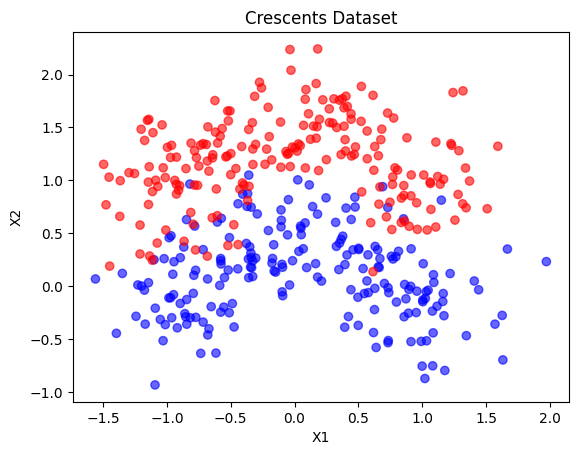

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def make_crescent_waves(n_samples=400, noise=0.3, random_state=42):
    np.random.seed(random_state)
    n = n_samples // 2
    theta = np.random.uniform(0, np.pi, n)

    # Class 0: Lower crescent
    x0 = np.cos(theta) + noise * np.random.randn(n)
    y0 = np.sin(theta) - 0.5 + noise * np.random.randn(n)

    # Class 1: Upper crescent
    x1 = np.cos(theta + np.pi) + noise * np.random.randn(n)
    y1 = -np.sin(theta + np.pi) + 0.5 + noise * np.random.randn(n)

    X = np.vstack((np.column_stack((x0, y0)), np.column_stack((x1, y1))))
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

X, y = make_crescent_waves(n_samples=400)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.title("Crescents Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()


Run 0 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
Run 0 Best Params: {'decay_factor': 0.99, 'epochs': 300, 'epsilon': 1e-05, 'lambda_reg': 0.001, 'learning_rate': 0.01, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 20, 'spline_type': 'cubic', 'track_history': True}


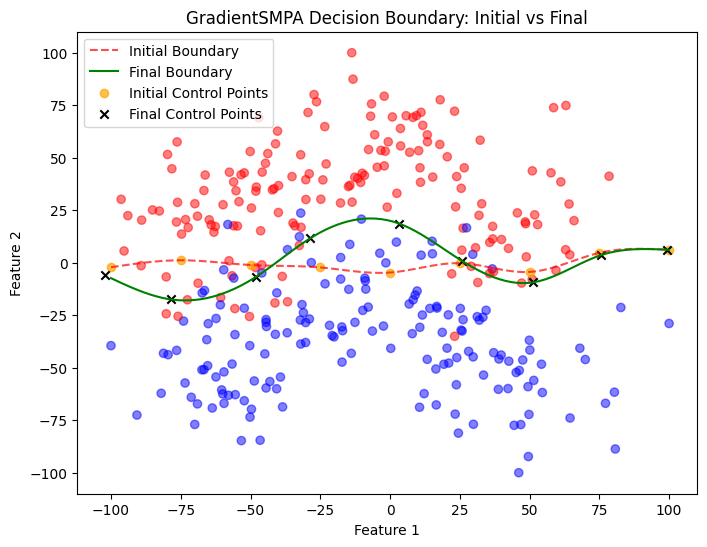

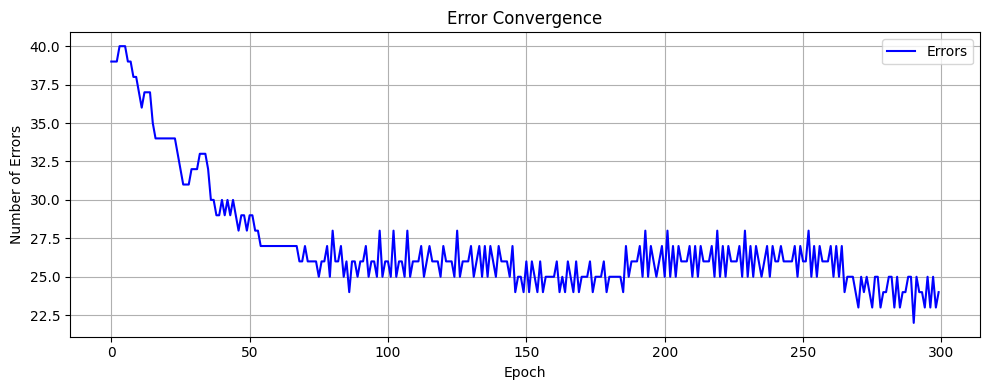

Run 0 Score: 0.9250

Run 1 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
Run 1 Best Params: {'decay_factor': 0.99, 'epochs': 300, 'epsilon': 1e-05, 'lambda_reg': 0, 'learning_rate': 0.01, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 20, 'spline_type': 'cubic', 'track_history': True}


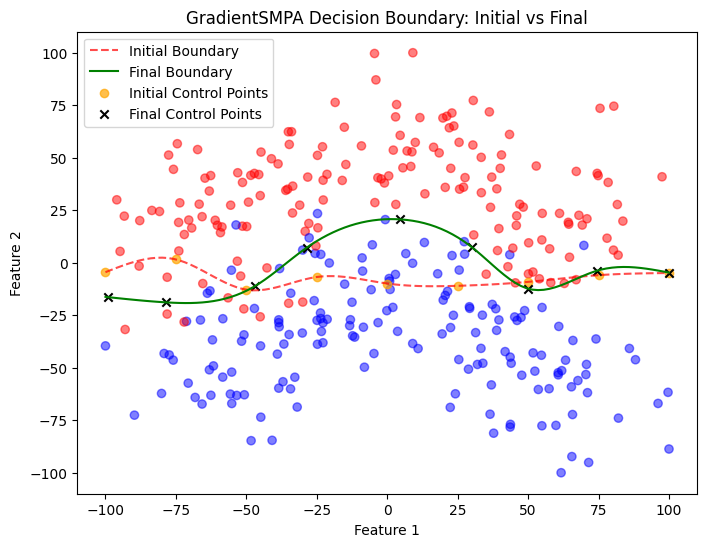

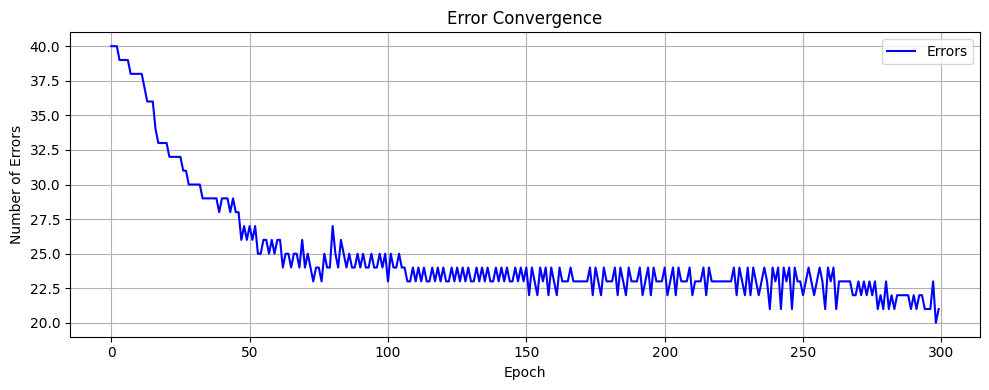

Run 1 Score: 0.9000

Run 2 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
Run 2 Best Params: {'decay_factor': 0.99, 'epochs': 300, 'epsilon': 0.01, 'lambda_reg': 0.001, 'learning_rate': 0.1, 'min_learning_rate': 1e-06, 'n_control_points': 9, 'patience': 20, 'spline_type': 'cubic', 'track_history': True}


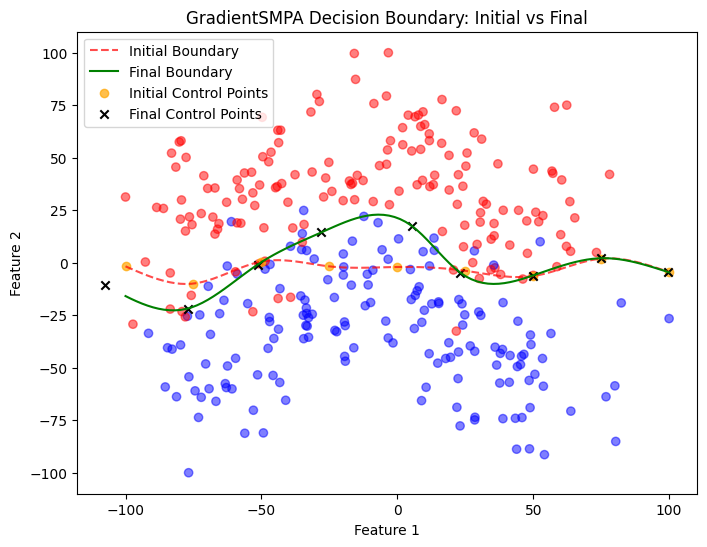

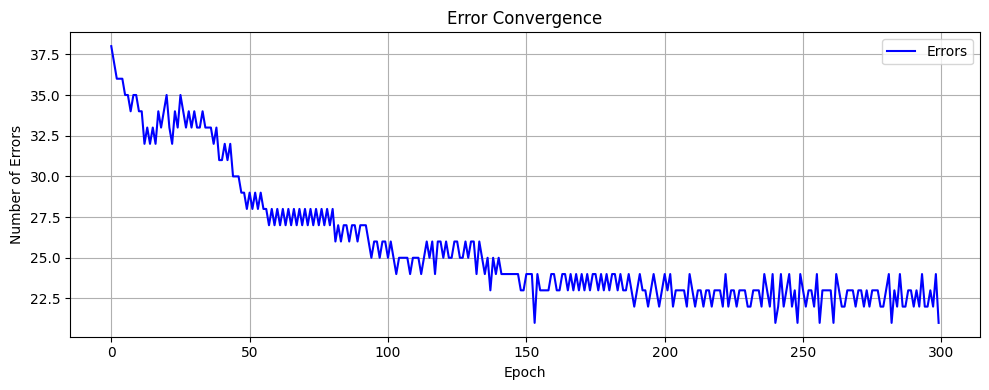

Run 2 Score: 0.9250

Run 3 for smpa...
Train Class Dist - [160 160]
Test Class Dist - [40 40]
Fitting 3 folds for each of 1536 candidates, totalling 4608 fits


In [ ]:
comparison = ClassifierComparison(X, y)

# Run all classifiers on same split
classifiers = ['smpa', 'svm', 'rf', 'dt']
results = {}
for clf_type in classifiers:
    results[clf_type] = comparison.stability_test(clf_type, n_runs=10)

for clf_type, res in results.items():
    print(f"\n📊 {clf_type.upper()} Stability:")
    print(f"Mean Score: {res['mean_score']:.4f}")
    print(f"Score Std Dev: {res['std_score']:.4f}")

comparison.statistical_significance_test(results, target='smpa')